In [29]:
import pandas as pd
import pingouin as pg
import seaborn as sb
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Load data and EDA

For this example we will work with a toy mouse dataset.
The dependent variable (`Weight`) is the weight of the mice taken at the end point of the experiment.
The independent variable (`Treatment group`) is the treatment received.
There are three treatments, placebo (`Control`), treatment one (`TX`) and treatment two (`TX2`).

In [2]:
file_name = "../data/mouse_one_way_anova.csv"
df = pd.read_csv(file_name)
df.head()

,Weight,Treatment group
0,48.275517,Control
1,52.280366,Control
2,58.197076,Control
3,44.986134,Control
4,50.694798,Control


First let's look at the sample size in each group.

In [3]:
df["Treatment group"].value_counts()

Treatment group
Control    5
TX         5
TX2        5
Name: count, dtype: int64

Descriptive statistics of the entire dataset.

In [4]:
df.describe()

,Weight
count,15.000000
mean,64.399840
std,24.028966
min,39.506421
25%,45.202288
50%,52.280366
75%,89.303894
max,108.798292


Descriptive statistics by treatment.

In [5]:
df.groupby("Treatment group").describe()

Weight                                                        \
                 count       mean       std        min        25%        50%   
Treatment group                                                                
Control            5.0  50.886778  4.925842  44.986134  48.275517  50.694798   
TX                 5.0  46.569426  8.403240  39.506421  43.336921  43.481124   
TX2                5.0  95.743316  8.503879  85.324611  93.283177  94.203665   

                                        
                       75%         max  
Treatment group                         
Control          52.280366   58.197076  
TX               45.418442   61.104221  
TX2              97.106833  108.798292

We can also assess the normality of the groups.
We will use the Shapiro-Wilks but other methods are [supported](https://pingouin-stats.org/build/html/generated/pingouin.normality.html).

In [14]:
pg.normality(
    data=df,
    dv="Weight",
    group="Treatment group",
    method="shapiro",
)

,W,pval,normal
Treatment group,,,
Control,0.978885,0.928568,True
TX,0.781479,0.056753,True
TX2,0.943969,0.694118,True


We have normality withing groups.
Let's visualise our data now.
Since the data within groups is normal we will plot the confidence intervals (95%) and mean.

Text(38.097222222222214, 0.5, 'Weight (g)')

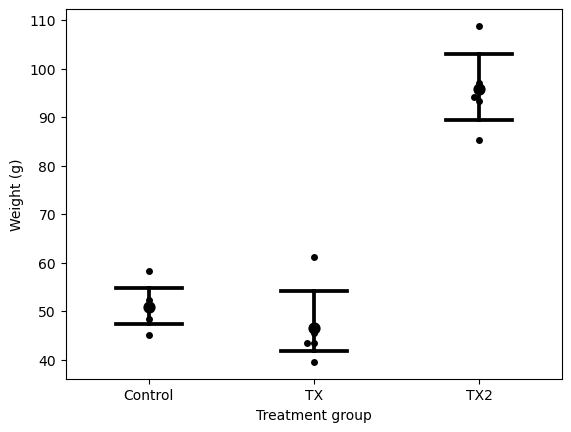

In [18]:
ax = sb.swarmplot(
    df,
    x="Treatment group",
    y="Weight",
    color="k",
)
ax = sb.pointplot(
    df,
    x="Treatment group",
    y="Weight",
    capsize=0.4,
    estimator="mean",
    errorbar=("ci", 95),
    linestyles="none",
    color="k",
)
ax.set_ylabel("Weight (g)")

## Analysis

Since we have three different treatment groups we will do a one way ANOVA.

In [22]:
pg.anova(data=df, dv="Weight", between="Treatment group")

,Source,ddof1,ddof2,F,p-unc,np2
0,Treatment group,2,12,66.5217,3.207005e-07,0.917266


The omnibus test shows signficance.
Now we can perform our post-hoc pairwise Tukey test to identify which differences are significant.

In [42]:
pg.pairwise_tukey(
    data=df,
    dv="Weight",
    between="Treatment group",
)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Control,TX,50.886778,46.569426,4.317352,4.721501,0.914402,6.418996e-01,0.566168
1,Control,TX2,50.886778,95.743316,-44.856538,4.721501,-9.500482,1.733133e-06,-5.830339
2,TX,TX2,46.569426,95.743316,-49.173890,4.721501,-10.414884,6.442948e-07,-5.253922


There is a significant difference between TX2 and the other treatment groups.
There is no signifcant difference between control and TX.

## Assumptions check

The one way anova assumes equality of variance.
We will use the homoscedasticity function which performs the Brown-Forsythe test.

In [40]:
pg.homoscedasticity(
    data=df,
    dv="Weight",
    group="Treatment group",
    # center="mean", # Converts to the Levene test used by JASP
)

,W,pval,equal_var
levene,0.153416,0.859429,True


We have equality of variance so the standard ANOVA assumption is not violated.
If we had a violation of this assumption we could instead use the [`welch_anova`](https://pingouin-stats.org/build/html/generated/pingouin.welch_anova.html) function.

We also need to test the normality of the residuals.
At the time of writing there is no support for getting the residuals in pingouin.
However, support will eventually be added.

To work around this we will uses the [statsmodels](https://www.statsmodels.org/stable/index.html) package.
The interface is a bit more complicated as we need to create an ordinary least squares object and get the residuals.

We need specify a linear model in what follows.
This may seem strange, as we are not doing regression explicitly.
However, there is a close connection between regression and ANOVA which is beyond the scope of this class.
Here we will use the R formula syntax where the dependent variable is seperated from the independent variable(s) by ~.

In [31]:
formula = 'Weight ~ Q("Treatment group")'
model = ols(formula, data=df).fit()
res = model.resid
res

0     -2.611261
1      1.393588
2      7.310298
3     -5.900644
4     -0.191980
5     -3.232505
6     14.534795
7     -7.063005
8     -1.150984
9     -3.088302
10   -10.418705
11     1.363517
12    -1.539650
13    -2.460139
14    13.054976
dtype: float64

Now we can test the normality of the residuals.
We will start with the Shapiro-Wilks test.

In [32]:
pg.normality(res)

,W,pval,normal
0,0.90041,0.096556,True


We do not reject the null hypothesis the residuals are Normally distributed.

It would also be good to visualise the residuals.

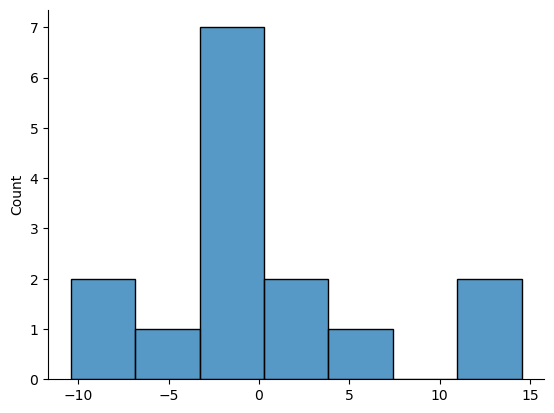

In [33]:
ax = sb.histplot(res)
sb.despine()

It is a bit hard to see that this is normal.
Let's check the Q-Q plot.

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

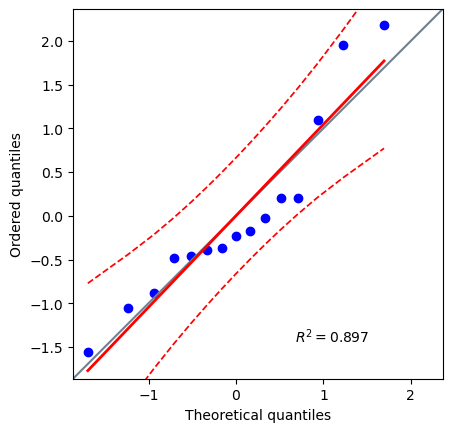

In [34]:
pg.qqplot(res)